In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rl_equation_solver
from rl_equation_solver.environment.algebraic import Env
from rl_equation_solver.agent.dqn import Agent as AgentDQN
from rl_equation_solver.agent.gcn import Agent as AgentGCN
from rl_equation_solver.agent.lstm import Agent as AgentLSTM
from rl_equation_solver.utilities import utilities
from rl_equation_solver.utilities.utilities import GraphEmbedding
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from rex import init_logger
from sympy import symbols, sqrt, simplify, expand, nsimplify, parse_expr, sympify
import sympy
import cProfile, pstats, io
from pstats import SortKey

In [3]:
init_logger(__name__, log_level='INFO')
init_logger('rl_equation_solver', log_level="INFO")

<Logger rl_equation_solver (INFO)>

In [4]:
# plot reward distribution
def plot_reward_dist(env):
    _, ax = plt.subplots(1, 1)
    ax.hist(env.best_history['reward'])
    ax.set_ylabel('Count')
    ax.set_xlabel('Reward')
    plt.show()

# plot complexity, loss, reward
def plot_trends(env):
    fig, ax = plt.subplots(1, 3, figsize=(10, 7))
    history = env.end_history
    x = np.arange(len(history['ep']))
    
    y = history['complexity']
    a, b = np.polyfit(x, y, 1)
    ax[0].scatter(x, y)
    ax[0].plot(a*x + b, color='r')
    
    y = history['loss']
    mask = np.array([i for i, v in enumerate(y) if not np.isnan(v)])
    mask = slice(mask[0], mask[-1] + 1)
    a, b = np.polyfit(x[mask], y[mask], 1)
    ax[1].scatter(x[mask], y[mask])
    ax[1].plot(x[mask], a*x[mask] + b, color='r')
    
    y = history['reward']
    a, b = np.polyfit(x, y, 1)
    ax[2].scatter(x, y)
    ax[2].plot(a*x + b, color='r')
    
    ax[0].set_title('Complexity')
    ax[1].set_title('Loss')
    ax[2].set_title('Reward')
    plt.show()
    

## Initialize Env and Agent ##
### Agent can be AgentGCN, AgentLSTM, AgentDQN ###

In [8]:
env = Env(order=2, config={'reward_function': 'diff_loss_reward'})
agent = AgentGCN(env, device='cuda:0')#, config={'tau': 0.05, 'eps_end': 0.05})

INFO - 2023-04-18 08:16:27,931 [algebraic.py:115] : Initializing environment with order=2, |S| = 11 x 128 = 1408
INFO - 2023-04-18 08:16:27,932 [algebraic.py:118] : Using reward function: diff_loss_reward.
INFO - 2023-04-18 08:16:27,933 [base.py:69] : Initialized Agent with config: {'batch_size': 64, 'gamma': 0.6, 'eps_start': 0.5, 'eps_end': 0.05, 'eps_decay_steps': 1000, 'eps_decay': None, 'tau': 0.5, 'learning_rate': 0.0001, 'hidden_size': 64, 'memory_cap': 10000, 'reset_steps': 100, 'state_dim': 128, 'feature_num': 100, 'grad_clip': 100, 'reward_function': 'diff_loss_reward'}
INFO - 2023-04-18 08:16:27,937 [gcn.py:37] : Initialized Agent with device cuda:0


## Train Agent ##

In [9]:
for _ in range(1):
    agent.train(20)

INFO - 2023-04-18 08:16:29,350 [base.py:246] : Running training routine for 20 episodes in eval=False mode.
INFO - 2023-04-18 08:16:30,193 [base.py:300] : 
Episode: 0, steps_done: 3. Solver terminated after 4 steps: total_reward = -1.000e+01, mean_loss = nan, state = 0**a1 - 1
INFO - 2023-04-18 08:16:30,276 [base.py:300] : 
Episode: 1, steps_done: 6. Solver terminated after 4 steps: total_reward = -1.400e+01, mean_loss = nan, state = 0/a0 - a0


c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\agent\base.py:291: RuntimeWarning: Mean of empty slice
  mean_loss = np.nanmean(self.history[current_episode]['loss'])


INFO - 2023-04-18 08:16:30,430 [base.py:300] : 
Episode: 2, steps_done: 10. Solver terminated after 5 steps: total_reward = -1.700e+01, mean_loss = nan, state = 0 + 2*1 - a0
INFO - 2023-04-18 08:16:30,588 [base.py:300] : 
Episode: 3, steps_done: 14. Solver terminated after 5 steps: total_reward = -2.700e+01, mean_loss = nan, state = (0**a0 - a0)**a0
INFO - 2023-04-18 08:16:30,738 [base.py:300] : 
Episode: 4, steps_done: 18. Solver terminated after 5 steps: total_reward = -1.700e+01, mean_loss = nan, state = (0 + 1 - a0)**a1
INFO - 2023-04-18 08:16:30,828 [base.py:300] : 
Episode: 5, steps_done: 21. Solver terminated after 4 steps: total_reward = -2.400e+01, mean_loss = nan, state = (0 - a0)/a0
INFO - 2023-04-18 08:16:30,959 [base.py:300] : 
Episode: 6, steps_done: 25. Solver terminated after 5 steps: total_reward = -3.100e+01, mean_loss = nan, state = (0**a1 - a0)**a1
INFO - 2023-04-18 08:16:31,189 [base.py:300] : 
Episode: 7, steps_done: 31. Solver terminated after 7 steps: total_rewa

In [10]:
history = env.best_history
best_i = np.argmax(history['reward'])
print(parse_expr(str(history['state'][best_i])))
print(history['reward'][best_i])

-a1/a0
117.0


c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\utilities\history.py:41: RuntimeWarning: All-NaN axis encountered
  out[k].append(np.nanmin(series[k]))
c:\users\bbent\repos\rl-equation-solver\rl_equation_solver\utilities\history.py:43: RuntimeWarning: All-NaN axis encountered
  out[k].append(np.nanmax(series[k]))


## Plot Reward Distribution ##

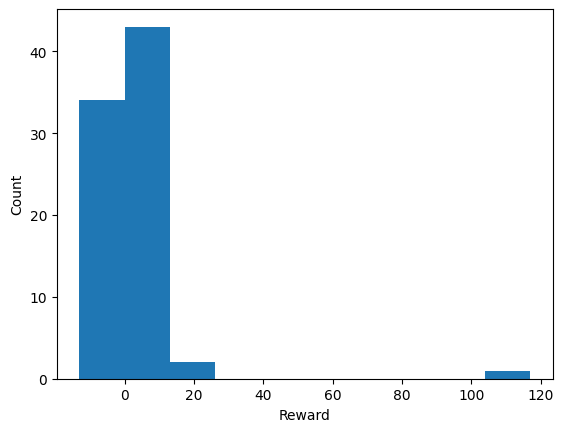

In [21]:
plot_reward_dist(env)

## Plot complexity, loss, and reward trend ##

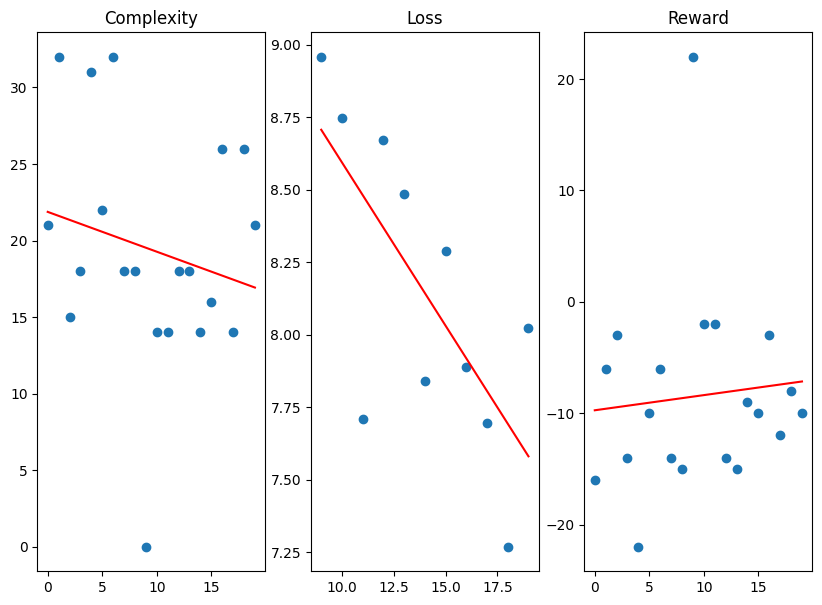

In [33]:
plot_trends(env)


## Run trained agent in eval mode ##

In [60]:
agent.train(50, eval=True)

INFO - 2023-04-18 05:49:41,091 [base.py:304] : Running training routine for 50 episodes in eval=True mode.
DEBUG - 2023-04-18 05:49:43,871 [history.py:76] : 
{'ep': 0, 'step': 17, 'complexity': 47.0, 'loss': 'nan', 'reward': '5.000e+00', 'state': 0/(a0**14*a1**2) - a0, 'approx': 0/(a0**13*a1**2) - a0**2 + a1}
INFO - 2023-04-18 05:49:43,958 [base.py:354] : 
Solver terminated after 19 steps: total_reward = -3.300e+01, mean_loss = 9.059e-01, state = 0/(a0**14*a1**2) - a0
DEBUG - 2023-04-18 05:49:45,015 [history.py:76] : 
{'ep': 1, 'step': 25, 'complexity': 33.0, 'loss': 'nan', 'reward': '2.000e+00', 'state': (0/a0**5)**a0/a1, 'approx': a0*(0/a0**5)**a0/a1 + a1}
INFO - 2023-04-18 05:49:45,096 [base.py:354] : 
Solver terminated after 9 steps: total_reward = -2.200e+01, mean_loss = 9.520e-01, state = (0/a0**5)**a0/a1
DEBUG - 2023-04-18 05:49:53,849 [history.py:76] : 
{'ep': 2, 'step': 80, 'complexity': 77.0, 'loss': 'nan', 'reward': '-8.000e+00', 'state': 0/(a0**45*a1**8) + 1, 'approx': 0/(a

## Plot reward distribution for trained agent ##

ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step
complexity
loss
reward
ep
step


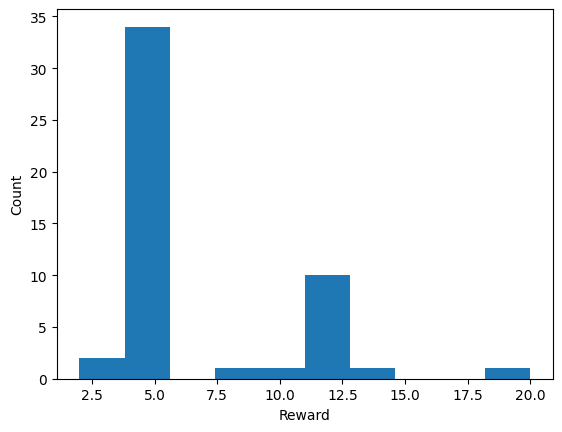

In [68]:
plot_reward_dist(env)

## Render final state graph ##

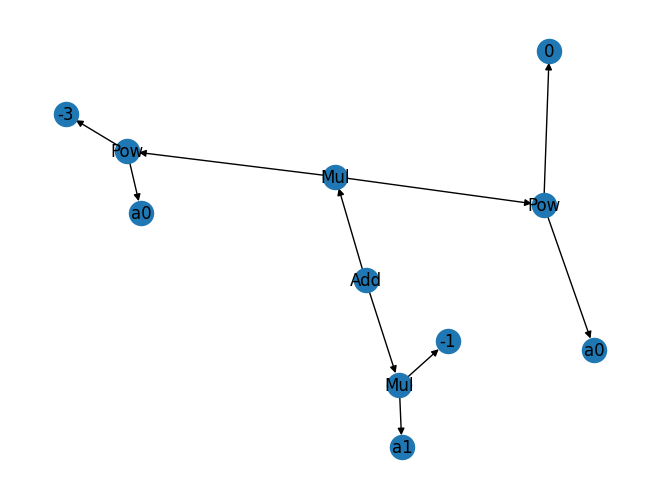

In [39]:
nx.draw(env.state_graph, labels=env.node_labels)

## Run new Agent in eval mode ##

In [150]:
env = Env(order=2)
agent = AgentGCN(env, device='cuda:0')
agent.train(30, eval=True)

INFO - 2023-04-17 13:10:35,160 [algebraic.py:112] : Initializing environment with order=2, |S| = 11 x 64 = 704
INFO - 2023-04-17 13:10:35,163 [gcn.py:37] : Initialized Agent with device cuda:0
INFO - 2023-04-17 13:10:35,169 [base.py:298] : Running training routine for 30 episodes in eval=True mode.
INFO - 2023-04-17 13:10:35,194 [history.py:76] : 
{'ep': 0, 'step': 1, 'complexity': 14.0, 'loss': 'nan', 'reward': '-8.000e+00', 'state': 1/a1, 'approx': a0/a1 + a1}
INFO - 2023-04-17 13:10:35,196 [base.py:347] : 
Solver terminated after 3 steps: total_reward = -1.700e+01, mean_loss = nan, state = 1/a1
INFO - 2023-04-17 13:10:35,306 [history.py:76] : 
{'ep': 1, 'step': 8, 'complexity': 18.0, 'loss': 'nan', 'reward': '-4.000e+00', 'state': a0 - a1, 'approx': a0*(a0 - a1) + a1}
INFO - 2023-04-17 13:10:35,309 [base.py:347] : 
Solver terminated after 8 steps: total_reward = -1.700e+01, mean_loss = nan, state = a0 - a1
INFO - 2023-04-17 13:10:35,344 [history.py:76] : 
{'ep': 2, 'step': 11, 'comp

## Plot reward distribution for untrained agent ##

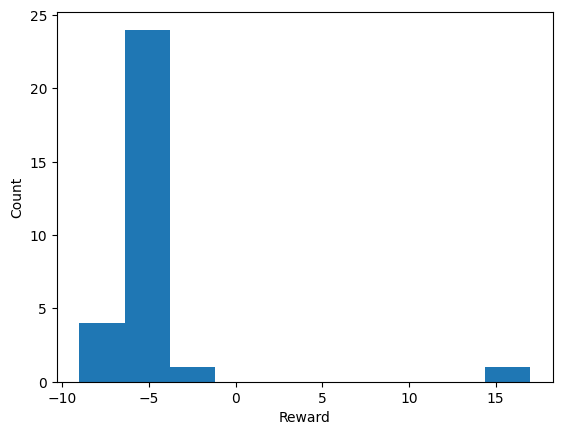

In [151]:
plot_reward_dist(env)